In [32]:
import numpy as np
import pandas as pd
import torch
import torch.nn.functional as F
import torchvision
import matplotlib.pyplot as plt
from time import time
from torchvision import datasets, transforms
from torch import nn, optim
from torch.utils.data import random_split
from sklearn.metrics import roc_auc_score, roc_curve, auc, confusion_matrix
import seaborn as sns

In [33]:
#@title Definição de datasets de treino, validação e teste

#Imagem será convertida em um tensor
transform =  transforms.ToTensor()

#Tamanho do batch para treinamento em lotes
batch_size = (64)

trainSet = datasets.MNIST('./MNIST_data/', download=True, train=True, transform=transform)
train_size = len(trainSet)

validation_ratio = 0.15
validation_size = int(validation_ratio * train_size)
train_size = train_size - validation_size
print("Imagens usadas para treino: {}\nImagens usadas para validação durante treino: {}".format(train_size, validation_size))

train_set, validation_set = random_split(trainSet, [train_size, validation_size])

trainLoader = torch.utils.data.DataLoader(train_set, batch_size=batch_size, shuffle=True)
validationLoader = torch.utils.data.DataLoader(validation_set, batch_size=batch_size, shuffle=True)

testSet = datasets.MNIST('./MNIST_data/', download=True, train=False,transform=transform)
testLoader = torch.utils.data.DataLoader(testSet, batch_size, shuffle=True)

Imagens usadas para treino: 51000
Imagens usadas para validação durante treino: 9000


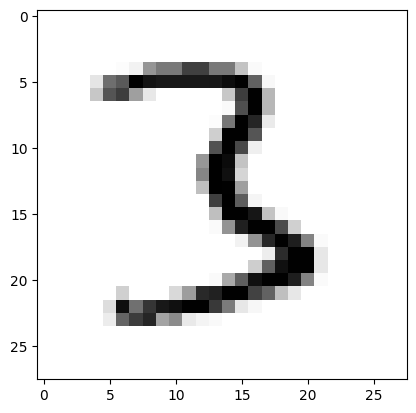

Shape da imagem: torch.Size([1, 28, 28])


In [34]:
#@title Visualização de uma imagem de exemplo
for img, label in trainLoader:
    plt.imshow(img[0].numpy().squeeze(), cmap='gray_r')
    plt.show()
    print("Shape da imagem:", img[0].shape)
    break

In [66]:
#@title Definição de funções de plot dos gráficos

def plot_class_distribution(loader, title):
    labels = np.array([])

    for _, batch_labels in loader:
        labels = np.concatenate((labels, batch_labels.numpy()))

    plt.figure(figsize=(10, 6))
    plt.hist(labels, bins=np.arange(-0.5, 10.5, 1), edgecolor='black', alpha=0.7)
    plt.title(title)
    plt.xlabel('Rótulo da classe')
    plt.ylabel('Frequência')
    plt.xticks(range(10))
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.show()

def plot_loss_curves(training_epoch_losses, validation_epoch_losses, plot_validation=True):
  plt.figure()

  title_prefix = 'treino e validação' if plot_validation else 'treino'
  plt.title(f'Relação entre época e perda considerando {title_prefix}')

  plt.xlabel("Época")
  plt.ylabel("Perda")

  # Estou plotando só a partir da segunda época, já que primeira normalmente pode
  # ser ligeiramente melhor que as épocas seguintes
  plt.plot(training_epoch_losses[1:], label="Perda de treino")

  if plot_validation:
    # Plotando a perda de validação
    plt.plot(validation_epoch_losses[1:], label="Perda de validação")

    # Calculando a faixa do eixo y
    merged_lists = training_epoch_losses[1:] + validation_epoch_losses[1:]
    highest_loss = max(merged_lists)
    lowest_loss = min(merged_lists)
    delta = highest_loss - lowest_loss

    # Ajustando a faixa do eixo y para incluir uma margem
    margin_factor = 0.05
    top_of_y_axis = highest_loss + (delta * margin_factor)
    bottom_of_y_axis = lowest_loss - (delta * margin_factor)

    plt.ylim([bottom_of_y_axis, top_of_y_axis])

  plt.grid(True)
  plt.legend()
  print()
  plt.show()

def plot_auc_curve(predictions, true_labels, num_classes=10):
  # Converter log de probabilidades para probabilidades reais
  probabilities = torch.softmax(torch.tensor(predictions), dim=1).numpy()

  # Certifique-se de que as dimensões estão corretas
  true_labels = true_labels.squeeze()

  plt.figure(figsize=(8, 8))

  for i in range(num_classes):
      class_labels = (true_labels == i).astype(int)
      class_probabilities = probabilities[:, i]

      # Calcule a curva ROC para cada classe
      fpr, tpr, _ = roc_curve(class_labels, class_probabilities, pos_label=1)
      roc_auc = auc(fpr, tpr)

      # Plote a curva ROC para cada classe
      plt.plot(fpr, tpr, label='Classe {} (AUC = {:.3f})'.format(i, roc_auc))

  plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
  plt.xlabel('Taxa de falso positivo')
  plt.ylabel('Taxa de verdadeiro positivo')
  plt.title('Curva ROC para cada classe')
  plt.legend()
  plt.show()

def plot_confusion_matrix(predictions, true_labels):
  conf_matrix = confusion_matrix(true_labels, predictions.argmax(axis=1))

  plt.figure(figsize=(10, 8))
  sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=range(10), yticklabels=range(10))
  plt.xlabel('Previsto')
  plt.ylabel('Verdadeiro')
  plt.title('Matriz de confusão')
  plt.show()

def plot_class_distribution(loader, title):
    labels = np.array([])

    for _, batch_labels in loader:
        labels = np.concatenate((labels, batch_labels.numpy()))

    plt.figure(figsize=(10, 6))
    plt.hist(labels, bins=np.arange(-0.5, 10.5, 1), edgecolor='black', alpha=0.7)
    plt.title(title)
    plt.xlabel('Rótulo da classe')
    plt.ylabel('Frequência')
    plt.xticks(range(10))
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.show()

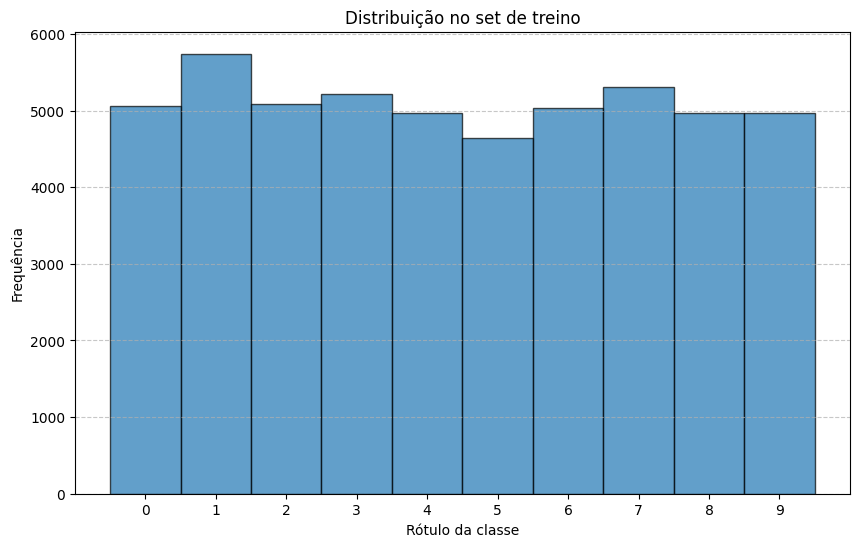

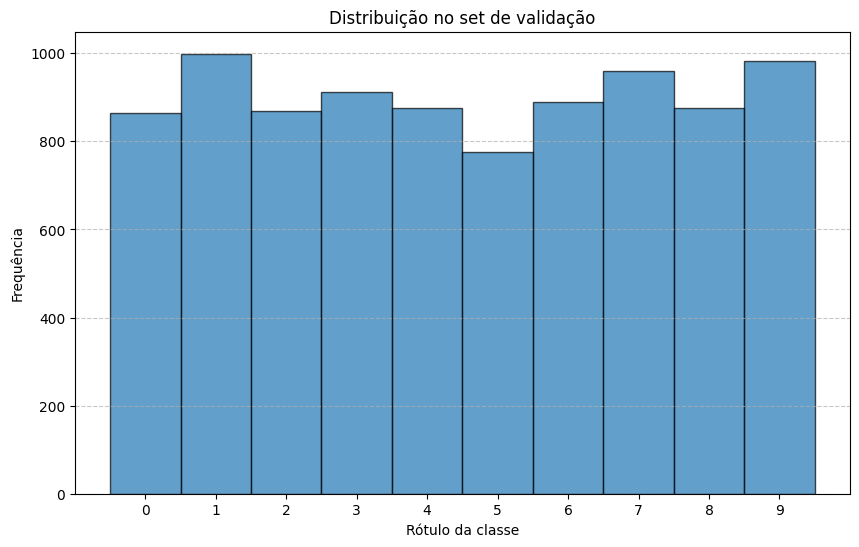

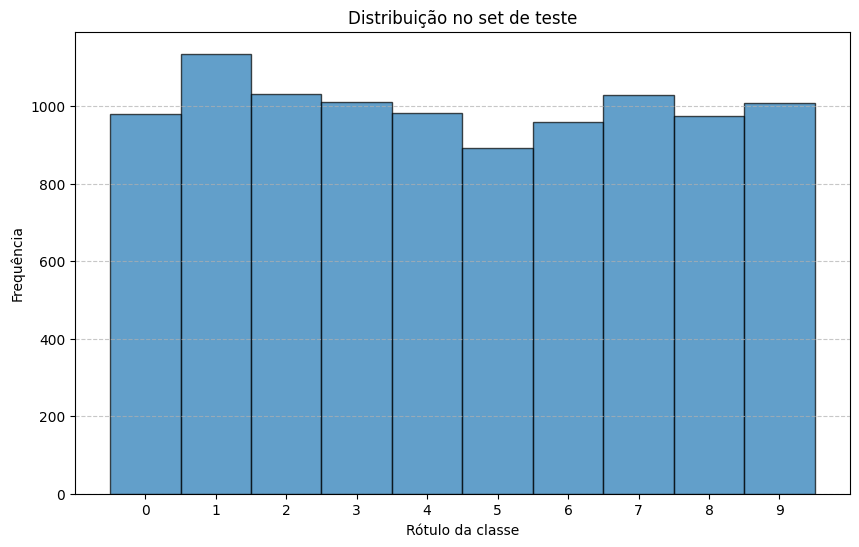

In [36]:
plot_class_distribution(trainLoader, 'Distribuição no set de treino')
plot_class_distribution(validationLoader, 'Distribuição no set de validação')
plot_class_distribution(testLoader, 'Distribuição no set de teste')

In [37]:
#@title Definição de classes do modelo
class Model(nn.Module):
  #Define as ligações dos neurônios no modelo
  def __init__(self):
    super(Model, self).__init__()
    self.linear1 = nn.Linear(28*28,128)
    self.linear2 = nn.Linear(128,64)
    self.linear3 = nn.Linear(64,10)

  def set_optimizer(self, learning_rate=0.01, momentum=0.5):
    self.optimizer = optim.SGD(self.parameters(), learning_rate, momentum)

  #Define funções de ativação em cada camada
  def forward(self,X):
    X = F.relu(self.linear1(X))
    X = F.relu(self.linear2(X))
    X = self.linear3(X)
    return F.log_softmax(X, dim=1)

In [61]:
#@title Definição de treino do modelo
def train(model, trainLoader, validationLoader, device, epochs=30):
  #Monitoramento do tempo de treino do modelo
  init = time()
  #Definindo erro a ser minimzado (Negative log likelihood loss)
  criterion = nn.NLLLoss()

  model.train()

  epoch_losses_train, epoch_losses_val = [], []

  for epoch in range(epochs):
    acm_loss_train, acm_loss_val = 0, 0
    predictions, true_labels = [], []

    for imgs, labels in trainLoader:

      # Ajustando a forma das imagens para corresponder à entrada da rede neural
      imgs = imgs.view(imgs.shape[0], -1)

      model.optimizer.zero_grad()

      # Realizando o forward pass (obtendo as previsões do modelo)
      output = model(imgs.to(device))

      instant_loss = criterion(output, labels.to(device))

      # Realizando o backward pass (cálculo dos gradientes)
      instant_loss.backward()

      # Atualização dos parâmetros
      model.optimizer.step()

      acm_loss_train += instant_loss.item()

    #validação
    model.eval()
    with torch.no_grad():
        for imgs_val, labels_val in validationLoader:
            imgs_val = imgs_val.view(imgs_val.shape[0], -1)
            output_val = model(imgs_val.to(device))
            instant_loss_val = criterion(output_val, labels_val.to(device))
            acm_loss_val += instant_loss_val.item()
            predictions.extend(output_val.cpu().numpy())
            true_labels.extend(labels_val.cpu().numpy())

    predictions = np.array(predictions)
    true_labels = np.array(true_labels)

    model.train()  # Voltando para o modo de treinamento

    # Calculando a perda média para a época atual (treinamento e validação)
    epoch_loss_train = acm_loss_train / len(trainLoader)
    epoch_loss_val = acm_loss_val / len(validationLoader)

    # Armazenando as perdas de treinamento e validação
    epoch_losses_train.append(epoch_loss_train)
    epoch_losses_val.append(epoch_loss_val)

  exec_time = (time()-init)/60
  print("\n Tempo de treinamento: {:.1f} minutos".format(exec_time))
  return epoch_losses_train, epoch_losses_val, predictions, true_labels

In [39]:
#@title Definição função de acurácia
def calculate_model_acc(modelo, valLoader, device):
  right_answer, all_answer = 0,0

  for imgs, labels in valLoader:
    for i in range(len(labels)):
      img = imgs[i].view(1,784)
      with torch.no_grad():
        logps = modelo(img.to(device))

      ps = torch.exp(logps)
      prob = list(ps.cpu().numpy()[0])
      label_pred = prob.index(max(prob))
      right_label = labels.numpy()[i]

      if(right_label == label_pred):
        right_answer += 1

      all_answer += 1

  print("All tested images:", all_answer)
  print("Model accuracy: {}%".format(right_answer*100/all_answer))

In [62]:
#@title Instanciação do modelo
model = Model()
model.set_optimizer()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

Model(
  (linear1): Linear(in_features=784, out_features=128, bias=True)
  (linear2): Linear(in_features=128, out_features=64, bias=True)
  (linear3): Linear(in_features=64, out_features=10, bias=True)
)

In [63]:
epoch_losses_train, epoch_losses_val, predictions, true_labels  = train(model, trainLoader, validationLoader, device, epochs=30)


 Tempo de treinamento: 5.1 minutos


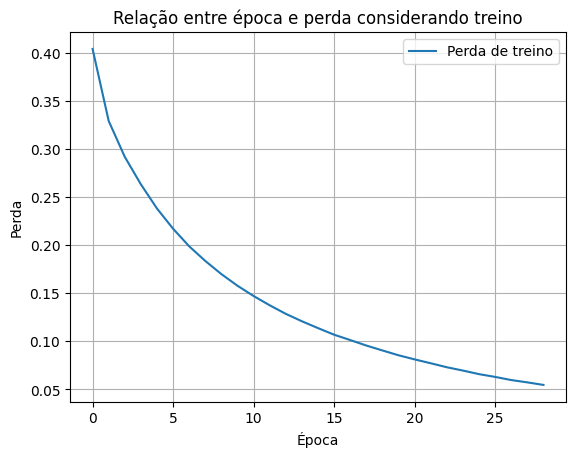

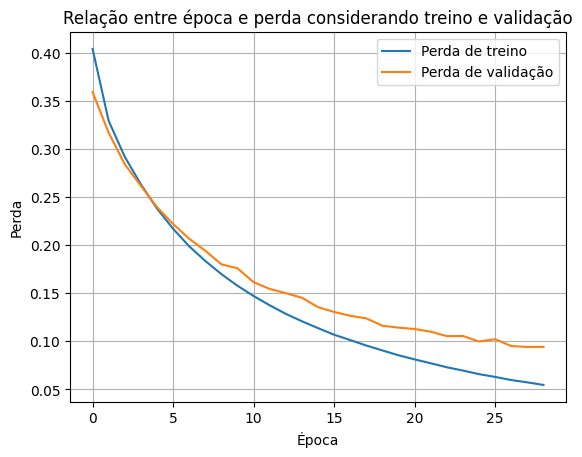

In [64]:
plot_loss_curves(epoch_losses_train, epoch_losses_val, False)
plot_loss_curves(epoch_losses_train, epoch_losses_val, True)

In [65]:
calculate_model_acc(model, testLoader, device)

All tested images: 10000
Model accuracy: 97.36%


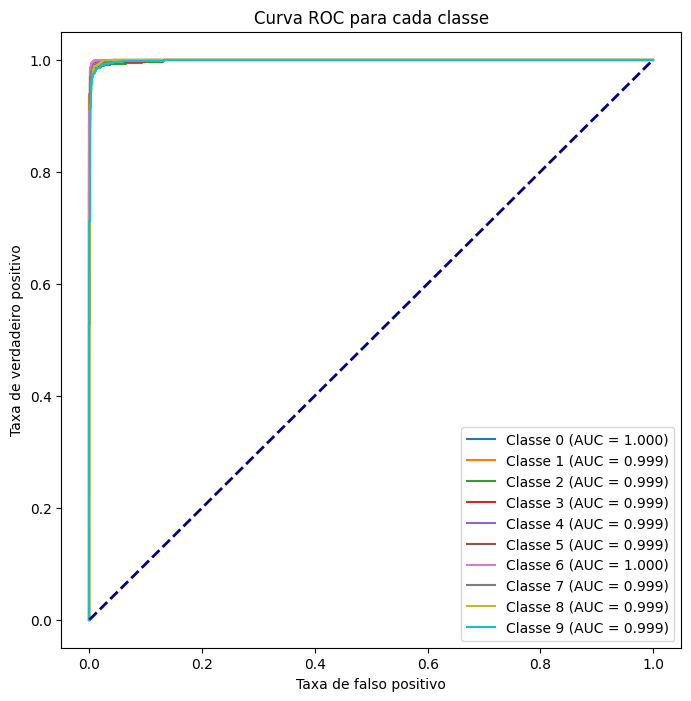

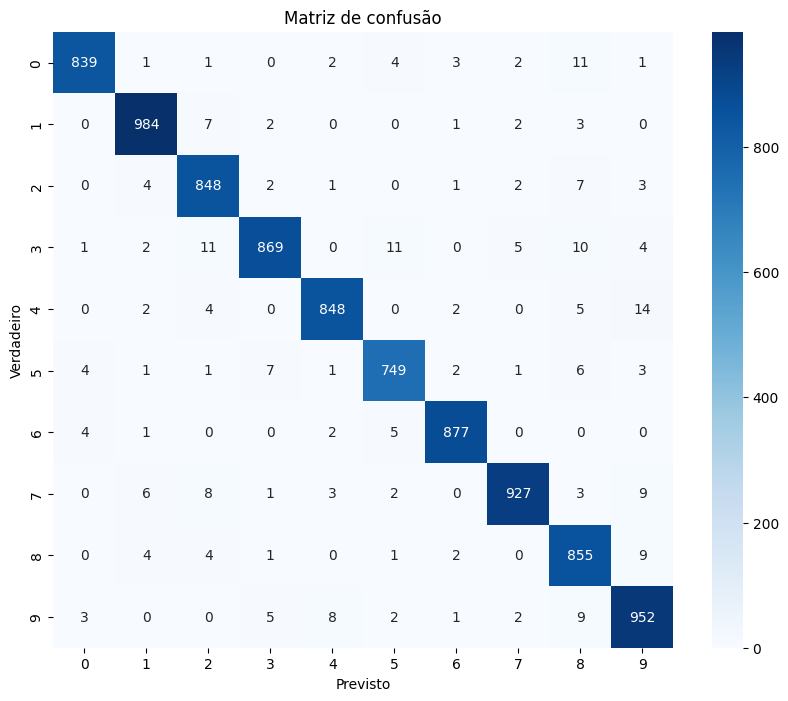

In [67]:
plot_auc_curve(predictions, true_labels)
plot_confusion_matrix(predictions, true_labels)